# Classification

In [1]:
# import necessary libraries
import pandas as pd  # for data input/output and processing
import numpy as np  # for matrix calculations

from sklearn.linear_model import LogisticRegression  # An already implemented version of logistic regression
from sklearn.preprocessing import PolynomialFeatures  # To transform our features to the corresponding polynomial version
from sklearn.metrics import accuracy_score, log_loss, zero_one_loss  # a way to evaluate how erroneous our model is

import matplotlib.pyplot as plt  # For visualizations

In [2]:
plt.rcParams.update({'font.size': 20})

## Data Preprocessing

Preprocessing refers to some data manipulation techniques that are used to make sure that our data carry important information in the format that we expect it to.

Here we are going to use a small dataset of only 89 samples. These correspond to meteorological observations from the [Finnish Meteorological Institute (FMI)](https://en.ilmatieteenlaitos.fi/download-observations).

In [3]:
# First load the dataset into a pandas DataFrame
df = pd.read_csv("fmi_nov_dec_2021.csv")
print("Number of data points:", len(df))
df.head(2)  # print the first 2 rows

Number of data points: 89


,Year,m,d,Time,Time zone,Precipitation amount (mm),Snow depth (cm),Air temperature (degC),Ground minimum temperature (degC),Maximum temperature (degC),Minimum temperature (degC)
0,2021,10,1,00:00,UTC,0.2,-1,9.8,NaN,11.2,8.2
1,2021,10,2,00:00,UTC,-1.0,-1,10.7,NaN,12.2,9.2


### Datapoints and Features vs. Labels

- **Datapoint**: A datapoint is a single row of our dataset that represents an object with specific properties.
- **Label**: Some property (i.e. a column of our dataset) that is a quantity of interest.
- **Features**: All of our dataset's columns that are not the target. It represents the amount of information that we think we need in order to predict the label.

**FMI Example:** 
- Our goal is to predict whether there is going to be a high or a low temperature.
- We will label as **high**, all temperatures above 5 degrees. The rest will be considered **low** temperatures.
- To make classification easier, the class **high** will be represented with the label **1** and the class **low** with **0**.
- We will **consider** the `day` and the `minimum temperature` as possible features.
- This way we get:
  - **Datapoint**: Represents whether we had a high or low temperature at a given day and minimum temperature.
  - **Label**: Temperature class - High or Low (1 or 0).
  - **Features**: `Day`, `Minimum Temperature`


In [4]:
feature_columns = ["d", "Minimum temperature (degC)"]
label_column = ["Maximum temperature (degC)"]
# Keep only relevant columns
df = df[feature_columns+label_column]
# Rename the columns to make access easier
df.columns = ['d', 'min_temp', 'max_temp']
df.head(2)

,d,min_temp,max_temp
0,1,8.2,11.2
1,2,9.2,12.2


We now need to process the `Maximum temperature (degC)` column and convert all values above $5$ to **1** and the rest to **0**.

In [5]:
# <new column> <`row` is a single entry of the df.max_temp Series>
df['label'] = df.max_temp.apply(lambda max_temp: 1 if max_temp > 5 else 0)
df.head(2)

,d,min_temp,max_temp,label
0,1,8.2,11.2,1
1,2,9.2,12.2,1


In [6]:
# Drop the max_temp column since we no longer need it
df.drop(columns=['max_temp'], inplace=True)
# Drop NaN (Not A Number) values
df.dropna(inplace=True)
df.head(2)

,d,min_temp,label
0,1,8.2,1
1,2,9.2,1


Now let's visualize the correlation of the remaining columns with the target variable. For this, we can simply make a scatter plot, as follows:

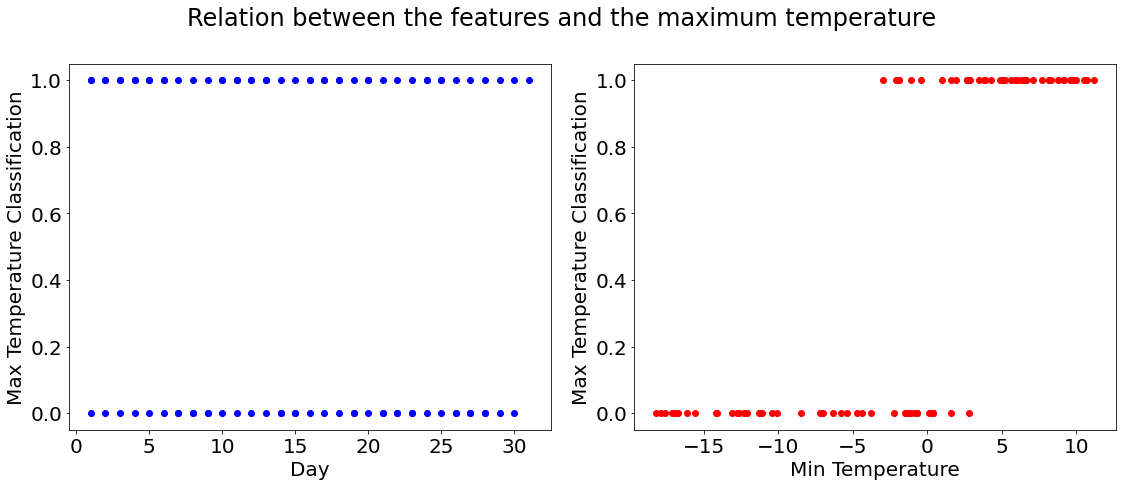

In [7]:
# def plot_model(X, y, 
fig=plt.figure(figsize=(16, 7))
fig.suptitle("Relation between the features and the maximum temperature")
plt.subplot(1, 2, 1)
plt.scatter(df.d, df.label, c="blue")
plt.xlabel("Day")
plt.ylabel("Max Temperature Classification")
plt.subplot(1, 2, 2)
plt.scatter(df.min_temp, df.label, c="red")
plt.xlabel("Min Temperature")
plt.ylabel("Max Temperature Classification")
fig.tight_layout()  # Separate the two subplots
plt.show()

The `d` column seems to have a very noisy relationship with the label. On the other hand, high `min_temp` values seem to correspond to high temperatures, while lower `min_temp` values lead to lower maximum temperatures.

For this reason we are going to completely ignore the `d` column and move on with the `min_temp` as our only feature. Using 1 feature also allows for better visualizations in a 2d space (e.g. if we had two features, then we would need 3 axes in total, and 3d plots are not as intuitive as 2d plots. If we had 3 features, then visualization would be impossible).

In [8]:
df.drop(columns=['d'], inplace=True)
print(len(df))
df.head(2)

89


,min_temp,label
0,8.2,1
1,9.2,1


In [9]:
# Let's separate features from labels
labels = df.label.values  # .values convert to a numpy array
features = df.drop(columns=['label']).values

## Logistic Regression

> Logistic regression is a ML method that allows to classify data points **according to two categories**. Thus, logistic regression is a **binary classification method** that can be applied to data points characterized by feature vectors $x \in \mathbf{R}^n$ (feature space $X = \mathbf{R}^n$) and binary labels $y$. 

> These binary labels take on values from a label space that contains two different label values. Each of these two label values represents one of the two categories to which the data points can belong.

> Note that logistic regression uses the same hypothesis space as linear regression.

> We can always obtain a predicted label $\hat{y} ∈ {0, 1}$ by comparing hypothesis value $h(x)$ with a threshold. A data point with features $x$, is classified as $\hat{y} = 1 \text{ if } h(x) ≥ 0 \text{ and } \hat{y}=0 \text{ for } h(x) < 0$.

### Loss Function

Logistic regression tries to minimize the empirical risk (average logistic loss): 
$$
\hat{L}(w|D) \stackrel{(*)}{=} \frac{1}{m} \sum_{i=1}^m log\left( 1+ exp\left( -y^{(i)} w^T x^{(i)}\right) \right)
$$

Our goal is to find the optimal vector $\hat{w}$ which minimizes the loss.

*(\*)The function $h$ is a linear combination of the input features: $h(x^{(i)}) = w_0 + \sum_{j=1}^{n} w_i x^{(i)}_j = w^T x^{(i)}$*

In [10]:
# Create a logistic regression model
lr = LogisticRegression()
# Fit the model to our data in order to get the most suitable parameters
lr = lr.fit(features, labels)

## Evaluation

- We are using the average logistic loss as a loss function which we try to minimize. The goal is to get its values as close to $0$ as possible.

- Even though "average logistic loss" is a very good loss function, it is not very intuitive and it cannot be used to compare different models.

- Instead, we opt to use the 0/1 loss, which is the opposite of the more commonly known "accuracy" ($0/1$ $loss = 1-accuracy$).

- Accuracy can be calculated as the ratio of correctly classified examples against the total number of examples.

In [11]:
# Calculate the mean square error on the training set
predictions = lr.predict(features)
zero_one_loss(predictions, labels)  # ideally this would be 0 which would mean that the number of incorrect predictions is close to 0

0.1348314606741573

In [12]:
log_loss(predictions, labels)  # this doesn't really tell us anything.

4.656967576668645

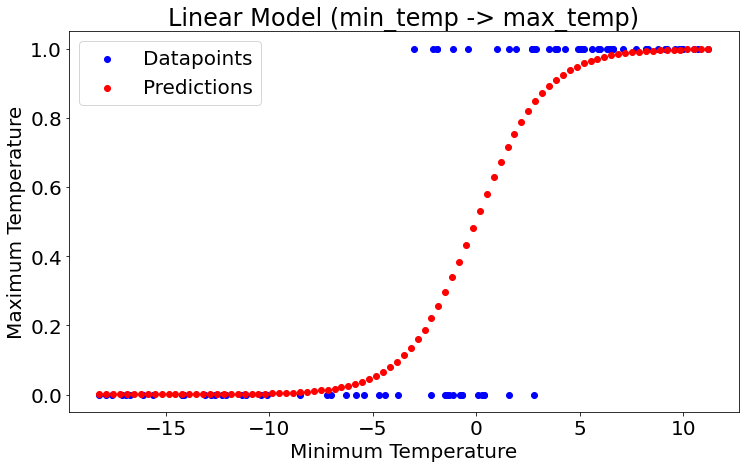

In [13]:
plt.figure(figsize=(12,7))
# How good does the model fit our data?
plt.scatter(features, labels, c="blue", label="Datapoints")
# an increasing vector in the [min, max] range of the features
X_line = np.linspace(features.min(), features.max(), len(features)).reshape(-1, 1)  # needs to be 2d and so we reshape
predictions = lr.predict_proba(X_line)[:, 1]
# plt.plot(X_line, predictions, c="red", label="Model")
plt.scatter(X_line, predictions, c='red', label="Predictions")
plt.xlabel("Minimum Temperature")
plt.ylabel("Maximum Temperature")
plt.title("Linear Model (min_temp -> max_temp)")
plt.legend()
plt.show()

## Increasing Model Size

Include terms of the feature values, raised to some power $r$ for some $r>1$:

$
\hat{h}(x) = w_0 + w_1 x + w_1 x^2 + ... + w_{r+1} x^r
$

To find the best value of $r$ we usually have to search through a lot of values, as follows:

In [14]:
def get_poly_predictor(features, labels, degree, **kwargs):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    # transform features so as to include their polynomial version.
    # E.g. feas_new will now also include x^2, ..., x^{degree}
    feas_new = poly_features.fit_transform(features)
    lr = LogisticRegression(**kwargs)
    lr.fit(feas_new, labels)
    model_preds = lr.predict(feas_new)
    zo = zero_one_loss(model_preds, labels)
    ll = log_loss(model_preds, labels)
    return zo, ll

In [15]:
# Try out different degrees and print the corresponding MSEs
for r in range(2, 8):
    zo, ll = get_poly_predictor(features, labels, degree=r, max_iter=500)
    print(f"Degree={r} -> 0/1 Loss={zo} -> Log Loss={ll}")

Degree=2 -> 0/1 Loss=0.1235955056179775 -> Log Loss=4.2688914373999856
Degree=3 -> 0/1 Loss=0.101123595505618 -> Log Loss=3.492757127344244
Degree=4 -> 0/1 Loss=0.101123595505618 -> Log Loss=3.4927481431034555
Degree=5 -> 0/1 Loss=0.0674157303370787 -> Log Loss=2.328483788334323
Degree=6 -> 0/1 Loss=0.0674157303370787 -> Log Loss=2.328483788334323
Degree=7 -> 0/1 Loss=0.0674157303370787 -> Log Loss=2.328483788334323


The errors decrease by a lot as we increase the degree. Does that mean that our model is better?

Let's make a scatter of the models for a degree of 2, 4, 6 and 7:

In [16]:
def poly_visualize(
        features, 
        labels, 
        degrees=[2, 4, 6, 7], 
        colors=['blue', 'green', 'cyan', 'purple'],
        **log_reg_kwargs,
    ):
    fig = plt.figure(figsize=(22, 18))
    wrong_poly_colors = ['gold', 'teal', 'tomato', 'firebrick', 'orchid']
    for i, r in enumerate(degrees):
        # ===================================================================
        # Fit model
        # ===================================================================
        poly_features = PolynomialFeatures(degree=r, include_bias=False)
        feas_new = poly_features.fit_transform(features)
        lr = LogisticRegression(**log_reg_kwargs)
        lr.fit(feas_new, labels)
        # ===================================================================
        # Scatter plot
        # ===================================================================
        plt.subplot(2, 2, i+1)
        # How good does the model fit our data?
        plt.scatter(features, labels, c=colors[i], label="Datapoints")
        # an increasing vector in the [min, max] range of the features
        X_line = np.linspace(features.min(), features.max(), 400).reshape(-1, 1)  # needs to be 2d and so we reshape
        predictions = lr.predict_proba(poly_features.transform(X_line))[:, 1]
        plt.plot(X_line, predictions, c="red", label="Best Fitted Model", linewidth=7.0)
        plt.xlabel("Minimum Temperature")
        plt.ylabel("Maximum Temperature Classification")
        zo = zero_one_loss(lr.predict(feas_new), labels)
        plt.title(f"Degree {r} - 0/1 Loss={round(zo, 2)}")
        plt.legend()
    plt.show()

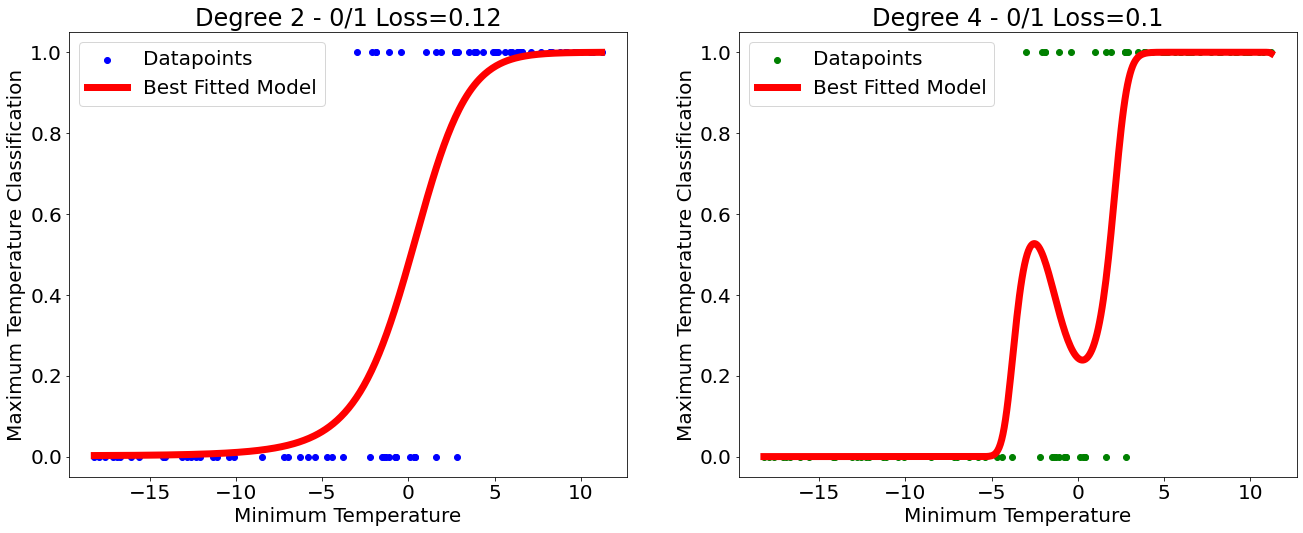

In [17]:
poly_visualize(features, labels, degrees=[2, 4], colors=["blue", "green"], max_iter=500)

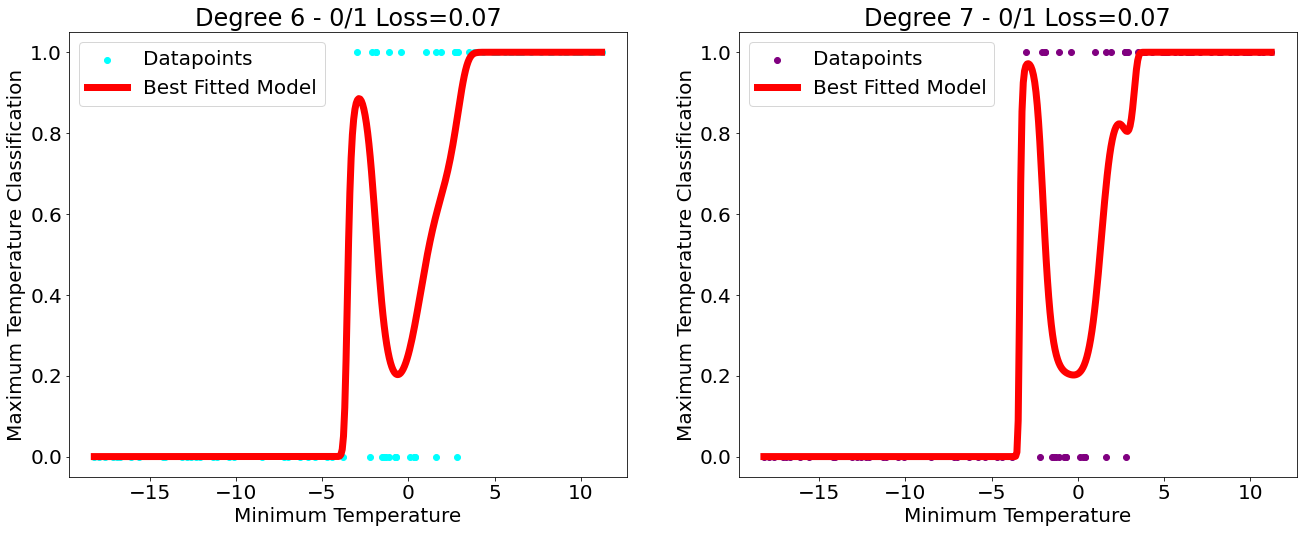

In [18]:
poly_visualize(features, labels, degrees=[6, 7], colors=["cyan", "purple"], max_iter=500)